In [1]:
import pandas as pd
from functools import reduce

from analysis_modules import compute_accuracy, plot, plot_metrics, analyze_errors, balance_df

In [5]:
# code used to create the data splits

# merging the proposals set with the different subsets (train, valid, test)
# CFS = pd.read_csv('../data/CoFE/CFS_without_debates_CFET.tsv', sep='\t')
# proposals = pd.read_csv('../data/CoFE/prop_CF_all.tsv', sep='\t')
# CoFE_train = pd.merge(proposals, CFS.drop('Topic', axis=1), left_on='id', right_on='id_prop', suffixes=('_prop', '_cm'))
# CoFE_train = CoFE_train.loc[:, ~CoFE_train.columns.duplicated()]
# CoFE_train.to_csv('../data/CoFE/CoFE_train.csv', index=None)

# keeping only samples where both the target and the comment are in either German, French or English (train set only)
# (to avoid balancing with rare languages and dropping too much data)
# CoFE_train_filtered = CoFE_train[CoFE_train['lan_prop'].isin(['de', 'fr', 'en']) & CoFE_train['lan_cm'].isin(['de', 'fr', 'en'])]

# adding a label column that is exactly the same as the alignment column for consistency during training (train set only)
# CoFE_train_filtered['label'] = CoFE_train_filtered['alignment']
# CoFE_train_filtered.to_csv('../data/CoFE/CoFE_train_filtered.csv', index=None)

# dropping the 'Other' label for consistency with the train set (valid set only)
# valid = pd.read_csv('../data/CoFE/CoFE_valid.csv')
# valid_filtered = valid[~(valid['label'] == 'Other')]
# valid_filtered.to_csv('../data/CoFE/CoFE_valid_filtered.csv', index=None)

In [10]:
# pd.read_csv('../data/CoFE/CoFE_train.csv')

In [4]:
# balance_df(pd.read_csv('../data/CoFE/CoFE_train_filtered.csv'), columns=['lan_cm', 'label'])

In [5]:
# import pickle

# with open('../models/xlmr+xstance/label_mapping.pickle', 'rb') as file:
#     label_mapping = pickle.load(file)

# label_mapping

{'FAVOR': 0, 'AGAINST': 1}

In [6]:
# label_map = {'In favor': 0, 'Against': 1}

# with open('../models/cofe_label_map.pickle', 'wb') as f:  
#     pickle.dump(label_map, f)

---

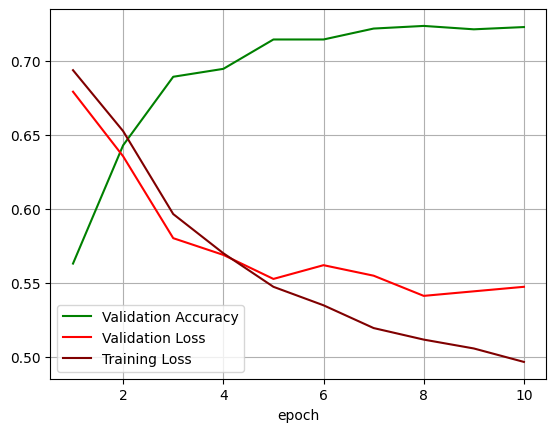

In [2]:
model_dir = "../models/xlmr+xstance_lora"
plot_metrics(model_dir)

In [3]:
# Vanilla XLM-Roberta predictions and accuracy
vanilla_xlmr_preds = pd.read_csv('../predictions/vanilla_XLM-R_preds.csv')
vanilla_xlmr_acc = compute_accuracy(vanilla_xlmr_preds, 'label', 'prediction')    # accuracy of always predicting 'AGAINST'

### Performance of fine-tuning using LoRA

In [4]:
xlmr_xstance_lora_preds = pd.read_csv('../predictions/xlmr+xstance_lora_preds.csv')
xlmr_xstance_lora_acc = compute_accuracy(xlmr_xstance_lora_preds, 'label', 'prediction')

In [5]:
xlmr_xstance_cofe_lora_preds = pd.read_csv('../predictions/xlmr+xstance+cofe_lora_preds.csv')
xlmr_xstance_cofe_lora_acc = compute_accuracy(xlmr_xstance_cofe_lora_preds, 'label', 'prediction')

In [6]:
# All accuracies combined

all_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    vanilla_xlmr_acc.rename(columns={'accuracy': 'acc_xlmr'}),
    xlmr_xstance_lora_acc.rename(columns={'accuracy': 'acc_xlmr+xstance (LoRA)'}),
    xlmr_xstance_cofe_lora_acc.rename(columns={'accuracy': 'acc_xlmr+xstance+cofe (LoRA)'})
])
all_acc

,language,acc_xlmr,acc_xlmr+xstance (LoRA),acc_xlmr+xstance+cofe (LoRA)
0,de,0.494660,0.690943,0.597427
1,fr,0.456502,0.741529,0.648810
2,it,0.460581,0.725450,0.638313


In [7]:
merged_lora_preds = pd.merge(xlmr_xstance_cofe_lora_preds, xlmr_xstance_lora_preds[['id', 'prediction']].rename(columns={'prediction': 'xstance_preds'}), on='id')
cofe_xstance_acc_wrt_xstance = compute_accuracy(merged_lora_preds, 'xstance_preds', 'prediction')
cofe_xstance_acc_wrt_xstance

,language,accuracy
0,de,0.744008
1,fr,0.772207
2,it,0.742739


### Performance of fine-tuning without LoRA

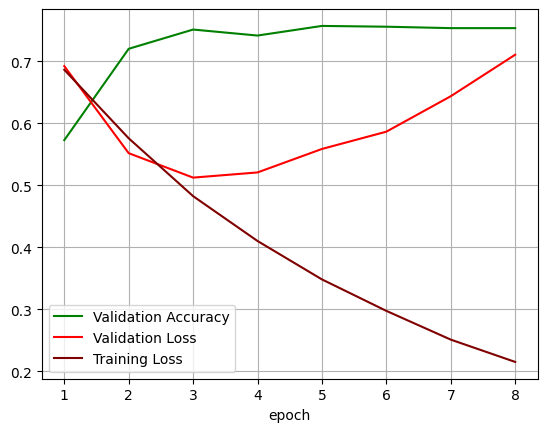

In [8]:
model_dir = "../models/xlmr+xstance"
plot_metrics(model_dir)

In [9]:
xlmr_xstance_preds = pd.read_csv('../predictions/xlmr+xstance_preds.csv')
xlmr_xstance_acc = compute_accuracy(xlmr_xstance_preds, 'label', 'prediction')

In [16]:
xlmr_xstance_cofe_preds = pd.read_csv('../predictions/xlmr+xstance+cofe_preds.csv')
xlmr_xstance_cofe_acc = compute_accuracy(xlmr_xstance_cofe_preds, 'label', 'prediction')

In [17]:
# All accuracies combined

all_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    vanilla_xlmr_acc.rename(columns={'accuracy': 'acc_xlmr'}),
    xlmr_xstance_acc.rename(columns={'accuracy': 'acc_xlmr+xstance'}),
    xlmr_xstance_cofe_acc.rename(columns={'accuracy': 'acc_xlmr+xstance+cofe'})
])
all_acc

,language,acc_xlmr,acc_xlmr+xstance,acc_xlmr+xstance+cofe
0,de,0.494660,0.723825,0.629131
1,fr,0.456502,0.765797,0.651557
2,it,0.460581,0.735823,0.613416


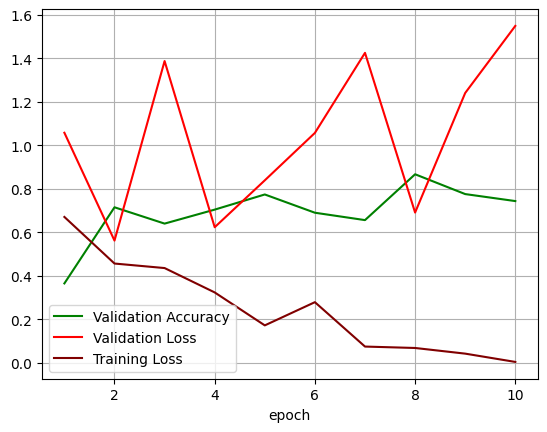

In [10]:
model_dir = "../models/xlmr+xstance+cofe"
plot_metrics(model_dir)

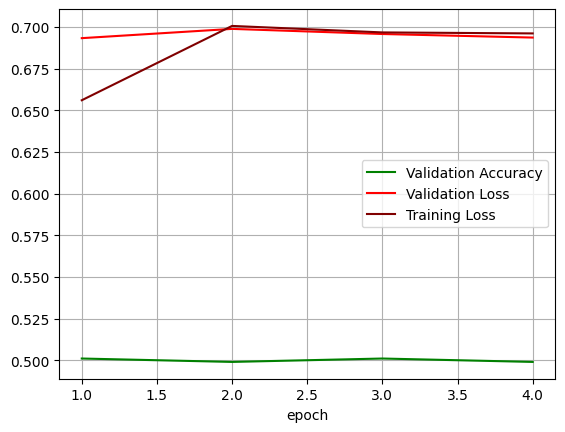

In [11]:
model_dir = "../models/xlmr+manifesto+xstance"
plot_metrics(model_dir)